In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

<h1>Define the Problem</h1>
<p>The sinking of the RMS Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

<p>One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

<p>In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. 

<h1>Module Import</h1>

In [1]:
# Load in our libraries
import pandas as pd #dataframe
import numpy as np #numerical process
import re #random play
import sklearn #ML god
import seaborn as sns #plot
import matplotlib.pyplot as plt #plot
import matplotlib as mpl
import matplotlib.pylab as pylab

# it's a library that we work with plotly
import plotly.offline as py 
py.init_notebook_mode(connected=True) # this code, allow us to work with offline plotly version
import plotly.graph_objs as go # it's like "plt" of matplot
import plotly.tools as tls # It's useful to we get some tools of plotly
import warnings # This library will be used to ignore some warnings
from collections import Counter # To do counter of some features

import warnings #ignore warnings
warnings.filterwarnings('ignore')

%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8


In [2]:
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

<h1>Understand The data</h1>

1. The Survived variable is our outcome or dependent variable. It is a binary nominal datatype of 1 for survived and 0 for did not survive. All other variables are potential predictor or independent variables. It's important to note, more predictor variables do not make a better model, but the right variables.
2. The PassengerID and Ticket variables are assumed to be random unique identifiers, that have no impact on the outcome variable. Thus, they will be excluded from analysis.
3. The Pclass variable is an ordinal datatype for the ticket class, a proxy for socio-economic status (SES), representing 1 = upper class, 2 = middle class, and 3 = lower class.
4. The Name variable is a nominal datatype. It could be used in feature engineering to derive the gender from title, family size from surname, and SES from titles like doctor or master. Since these variables already exist, we'll make use of it to see if title, like master, makes a difference.
5. The Sex and Embarked variables are a nominal datatype. They will be converted to dummy variables for mathematical calculations.
6. The Age and Fare variable are continuous quantitative datatypes.
7. The SibSp represents number of related siblings/spouse aboard and Parch represents number of related parents/children aboard. Both are discrete quantitative datatypes. This can be used for feature engineering to create a family size and is alone variable.
8. The Cabin variable is a nominal datatype that can be used in feature engineering for approximate position on ship when the incident occurred and SES from deck levels. However, since there are many null values, it does not add value and thus is excluded from analysis.

In [3]:
pd.set_option("display.max_columns",15)
#import training data
train=pd.read_csv("../input/train.csv")
#import testing data
test=pd.read_csv("../input/test.csv")

print(train.head())
print(test.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
  

<h1>Basic data utils</h1>



In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In both the cases we have Age column ,cabin,Embarked and Fare as missing values

In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
train.describe(include=["O"])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Rice, Master. Arthur",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


In [8]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [9]:
test.describe(include=["O"])

,Name,Sex,Ticket,Cabin,Embarked
count,418,418,418,91,418
unique,418,2,363,76,3
top,"Snyder, Mr. John Pillsbury",male,PC 17608,B57 B59 B63 B66,S
freq,1,266,5,3,270


By looking at the data we can understand that passengerID, Name And Ticket is basic informations and can't contribute to our target so get rid of them like your old school gf.

In [10]:
train_df=train.drop(["Name","Ticket","PassengerId"],axis=1)
test_df=test.drop(["Name","Ticket","PassengerId"],axis=1)

In [11]:
train_df.head(),test_df.head()

(   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Cabin Embarked
 0         0       3    male  22.0      1      0   7.2500   NaN        S
 1         1       1  female  38.0      1      0  71.2833   C85        C
 2         1       3  female  26.0      0      0   7.9250   NaN        S
 3         1       1  female  35.0      1      0  53.1000  C123        S
 4         0       3    male  35.0      0      0   8.0500   NaN        S,
    Pclass     Sex   Age  SibSp  Parch     Fare Cabin Embarked
 0       3    male  34.5      0      0   7.8292   NaN        Q
 1       3  female  47.0      1      0   7.0000   NaN        S
 2       2    male  62.0      0      0   9.6875   NaN        Q
 3       3    male  27.0      0      0   8.6625   NaN        S
 4       3  female  22.0      1      1  12.2875   NaN        S)

Well Now we have the basic 8 variables to predict the survival rate

<h1>Handleing Missing Values</h1>

<p>we are using Age missing values as its median ,Embarkment as mode and fare as median for the reason stated in visualization 

<h1>Target Analysis</h1>

In [12]:
trace0 = go.Bar(
            x = train_df[train_df["Survived"]== 1]["Survived"].value_counts().index.values,
            y = train_df[train_df["Survived"]==1]["Survived"].value_counts().values,
            name='Survived'
    )

trace1 = go.Bar(
            x = train_df[train_df["Survived"]== 0]["Survived"].value_counts().index.values,
            y = train_df[train_df["Survived"]== 0]["Survived"].value_counts().values,
            name='Not Survived'
    )

data = [trace0, trace1]

layout = go.Layout(
    
)

layout = go.Layout(
    yaxis=dict(
        title='Count'
    ),
    xaxis=dict(
        title='Survival Variable'
    ),
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='grouped-bar')

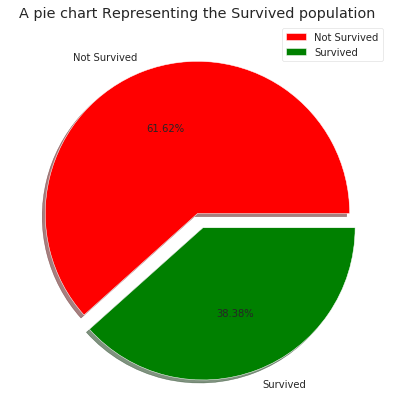

In [13]:
labels = ['Not Survived','Survived']
size = train_df['Survived'].value_counts()
colors = ['red', 'green']
explode = [0, 0.1]

plt.rcParams['figure.figsize'] = (7, 7)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('A pie chart Representing the Survived population')
plt.axis('off')
plt.legend()
plt.show()

So our train data contains data where around 38.5% persons are surviving out of 100%

<h1>Visualization</h1>

In [14]:
df_survived = train_df.loc[train_df["Survived"] == 1]['Age'].values.tolist()
df_notsurvived = train_df.loc[train_df["Survived"] == 0]['Age'].values.tolist()
df_age = train_df['Age'].values.tolist()

#First plot
trace0 = go.Histogram(
    x=df_survived,
    histnorm='probability',
    name="survived Persons"
)
#Second plot
trace1 = go.Histogram(
    x=df_notsurvived,
    histnorm='probability',
    name="Died Persons"
)
#Third plot
trace2 = go.Histogram(
    x=df_age,
    histnorm='probability',
    name="Overall Age"
)

#Creating the grid
fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Survived','Died', 'General Distribuition'))

#setting the figs
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)

fig['layout'].update(showlegend=True, title='Age Distribuition', bargap=0.05)
py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3           -      ]



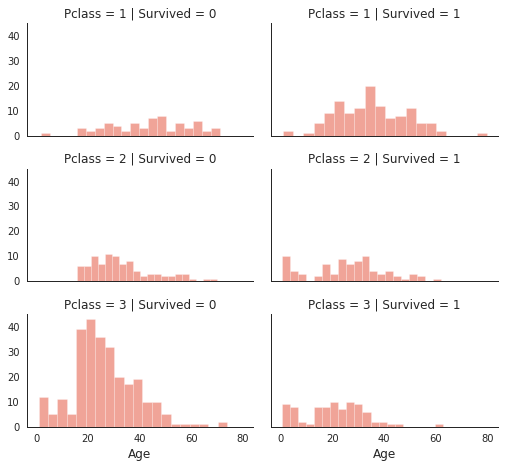

In [15]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid = sns.FacetGrid(train_df, col='Survived',palette="hue",row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

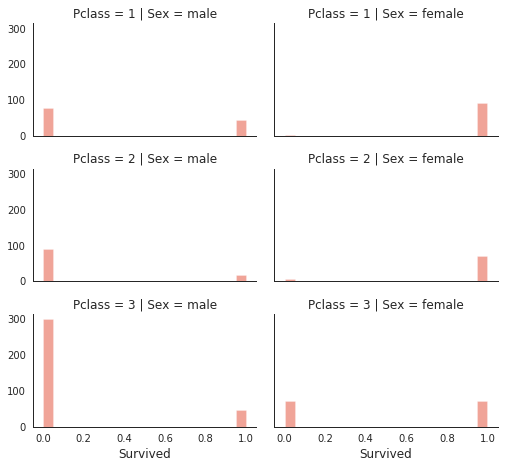

In [16]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid = sns.FacetGrid(train_df, col='Sex',palette="hue",row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist,'Survived', alpha=.5, bins=20)
grid.add_legend();

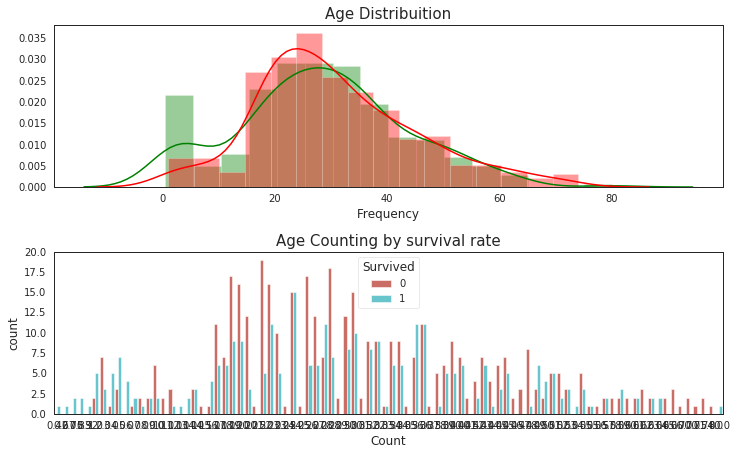

In [17]:
df_survived = train_df[train_df["Survived"] == 1]
df_notsurvived = train_df[train_df["Survived"] == 0]

fig, ax = plt.subplots(nrows=2, figsize=(12,8))
plt.subplots_adjust(hspace = 0.4, top = 0.8)

g1 = sns.distplot(df_survived["Age"].dropna(), ax=ax[0], 
             color="g")
g1 = sns.distplot(df_notsurvived["Age"].dropna(), ax=ax[0], 
             color='r')
g1.set_title("Age Distribuition", fontsize=15)
g1.set_xlabel("Age")
g1.set_xlabel("Frequency")

g2 = sns.countplot(x="Age",data=train_df, 
              palette="hls", ax=ax[1], 
              hue = "Survived")
g2.set_title("Age Counting by survival rate", fontsize=15)
g2.set_xlabel("Age")
g2.set_xlabel("Count")
plt.show()

In [18]:
#Let's look the Credit Amount column
interval = (0, 20, 40, 60, 80)

cats = ['Child', 'Young', 'Mature', 'Senior']
train_df["Age_cat"] = pd.cut(train_df.Age, interval, labels=cats)


df_survived = train_df[train_df["Survived"] == 1]
df_notsurvived = train_df[train_df["Survived"] == 0]

In [19]:
trace0 = go.Box(
    y=df_survived["Fare"],
    x=df_survived["Age_cat"],
    name='Survived',
    marker=dict(
        color='#3D9970'
    )
)

trace1 = go.Box(
    y=df_notsurvived['Fare'],
    x=df_notsurvived['Age_cat'],
    name='NotSurvived',
    marker=dict(
        color='#FF4136'
    )
)
    
data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Fare Amount',
        zeroline=False
    ),
    xaxis=dict(
        title='Age Categorical'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

In [20]:
df_male = train_df[train_df["Sex"] == "male"]
df_female = train_df[train_df["Sex"] == "female"]


trace0 = go.Box(
    y=df_male["Fare"],
    x=df_male["Age_cat"],
    name='Male',
    marker=dict(
        color='#3D9970'
    )
)

trace1 = go.Box(
    y=df_female['Fare'],
    x=df_female['Age_cat'],
    name='Female',
    marker=dict(
        color='#FF4136'
    )
)
    
data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Fare Amount',
        zeroline=False
    ),
    xaxis=dict(
        title='Age Categorical'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat-sex')

In [21]:
df_1 = train_df[train_df["Pclass"] == 1]
df_2 = train_df[train_df["Pclass"] == 2]
df_3=train_df[train_df["Pclass"] == 3]


trace0 = go.Box(
    y=df_1["Fare"],
    x=df_1["Age_cat"],
    name='Pclass1',
    marker=dict(
        color='#3D9970'
    )
)

trace1 = go.Box(
    y=df_2['Fare'],
    x=df_2['Age_cat'],
    name='Pclass2',
    marker=dict(
        color='#FF4136'
    )
    
)

trace2 = go.Box(
    y=df_3['Fare'],
    x=df_3['Age_cat'],
    name='Pclass3',
    marker=dict(
        color='black'
    )
    
)
    
data = [trace0, trace1,trace2]

layout = go.Layout(
    yaxis=dict(
        title='Fare Amount',
        zeroline=False
    ),
    xaxis=dict(
        title='Age Categorical'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat-pclass')

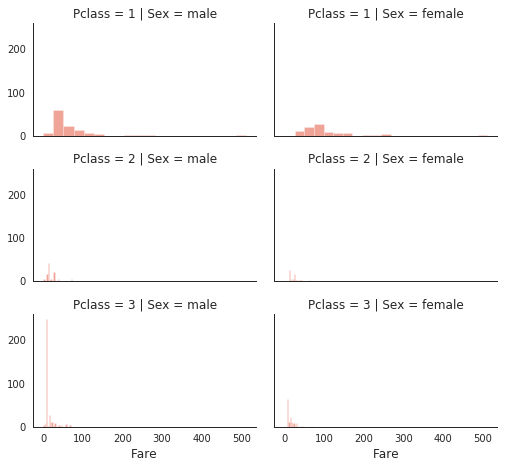

In [22]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid = sns.FacetGrid(train_df,palette="hue",row='Pclass',col="Sex", size=2.2, aspect=1.6)
grid.map(plt.hist, 'Fare', alpha=.5, bins=20)
grid.add_legend();

In [23]:
#First plot
trace0 = go.Bar(
    x =train_df[train_df["Survived"]== 1]["Pclass"].value_counts().index.values,
    y = train_df[train_df["Survived"]== 1]["Pclass"].value_counts().values,
    name='Survived',marker=dict(color="black")
)

#Second plot
trace1 = go.Bar(
    x = train_df[train_df["Survived"]== 0]["Pclass"].value_counts().index.values,
    y = train_df[train_df["Survived"]== 0]["Pclass"].value_counts().values,
    name="Not Survived",marker=dict(color="darkred")
)

data = [trace0, trace1]

layout = go.Layout(
    title='class Distribuition'
)


fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='class-Grouped')

In [24]:
fig = {
    "data": [
        {
            "type": 'violin',
            "x": df_survived['Pclass'],
            "y": df_survived['Fare'],
            "legendgroup": 'Survived',
            "scalegroup": 'No',
            "name": 'Survived',
            "side": 'negative',
            "box": {
                "visible": True
            },
            "meanline": {
                "visible": True
            },
            "line": {
                "color": 'blue'
            }
        },
        {
            "type": 'violin',
            "x": df_notsurvived['Pclass'],
            "y": df_notsurvived['Fare'],
            "legendgroup": 'Not Survived',
            "scalegroup": 'No',
            "name": 'Not Survived',
            "side": 'positive',
            "box": {
                "visible": True
            },
            "meanline": {
                "visible": True
            },
            "line": {
                "color": 'green'
            }
        }
    ],
    "layout" : {
        "yaxis": {
            "zeroline": False,
        },
        "violingap": 0,
        "violinmode": "overlay"
    }
}


py.iplot(fig, filename = 'violin/split', validate = False)

In [25]:
fig = {
    "data": [
        {
            "type": 'box',
            "x": df_survived['Pclass'],
            "y": df_survived['Fare'],
        "legendgroup": 'Survived',
            "scalegroup": 'No',
            "name": 'Survived',
            "side": 'negative',
            "box": {
                "visible": True
            },
            "meanline": {
                "visible": True
            },
            "line": {
                "color": 'red'
            }} ,
        {
            "type": 'box',
            "x": df_notsurvived['Pclass'],
            "y": df_notsurvived['Fare'],"legendgroup": 'Not Survived',
            "scalegroup": 'No',
            "name": 'Not Survived',
            "side": 'positive',
            "box": {
                "visible": True
            },
            "meanline": {
                "visible": True
            },
            "line": {
                "color": 'yellow'
            }
        }],
    "layout" : {
        "yaxis": {
            "zeroline": False,
        }
    }
}


py.iplot(fig, filename = 'violin/split', validate = False)

In [26]:
#First plot
trace0 = go.Bar(
    x = train_df[train_df["Survived"]== 1]["Sex"].value_counts().index.values,
    y = train_df[train_df["Survived"]== 1]["Sex"].value_counts().values,
    name='Survived'
)

#First plot 2
trace1 = go.Bar(
    x = train_df[train_df["Survived"]== 0]["Sex"].value_counts().index.values,
    y = train_df[train_df["Survived"]== 0]["Sex"].value_counts().values,
    name="Not Survived"
)

#Second plot
trace2 = go.Box(
    x = train_df[train_df["Survived"]== 1]["Sex"],
    y = train_df[train_df["Survived"]== 1]["Fare"],
    name=trace0.name
)

#Second plot 2
trace3 = go.Box(
    x = train_df[train_df["Survived"]== 0]["Sex"],
    y = train_df[train_df["Survived"]== 0]["Fare"],
    name=trace1.name
)

data = [trace0, trace1, trace2,trace3]


fig = tls.make_subplots(rows=1, cols=2, 
                        subplot_titles=('Sex Count', 'Fare by Sex'))

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 2)

fig['layout'].update(height=400, width=800, title='Sex Distribuition', boxmode='group')
py.iplot(fig, filename='sex-subplot')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [27]:

#First plot
trace0 = go.Bar(
    x = train_df[train_df["Survived"]== 1]["Embarked"].value_counts().index.values,
    y = train_df[train_df["Survived"]== 1]["Embarked"].value_counts().values,
    name='Survived'
)

#Second plot
trace1 = go.Bar(
    x = train_df[train_df["Survived"]== 0]["Embarked"].value_counts().index.values,
    y = train_df[train_df["Survived"]== 0]["Embarked"].value_counts().values,
    name="Not Survived"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Embarked Distribuition'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='grouped-bar')

In [28]:

trace0 = go.Box(
    x=df_survived["Embarked"],
    y=df_survived["Fare"],
    name='Survived'
)

trace1 = go.Box(
    x=df_notsurvived['Embarked'],
    y=df_notsurvived['Fare'],
    name='Not Survived'
)
    
data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Fare Amount distribuition by Embarkment'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

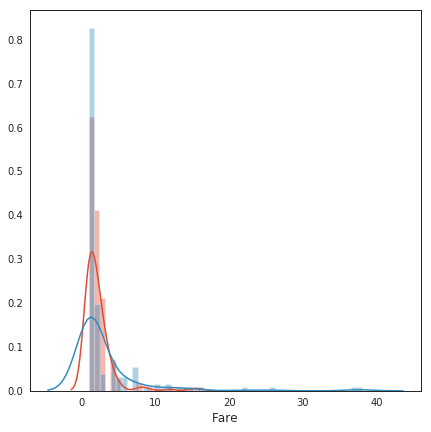

In [29]:
sns.distplot(train_df[train_df["Survived"]== 1]["Fare"].value_counts())
sns.distplot(train_df[train_df["Survived"]== 0]["Fare"].value_counts())


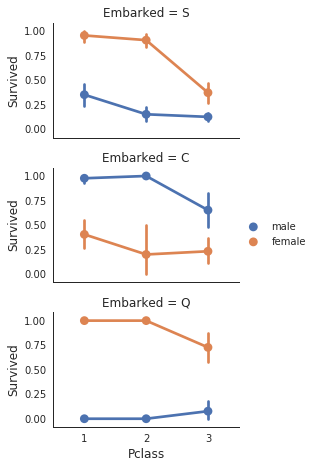

In [30]:
grid = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

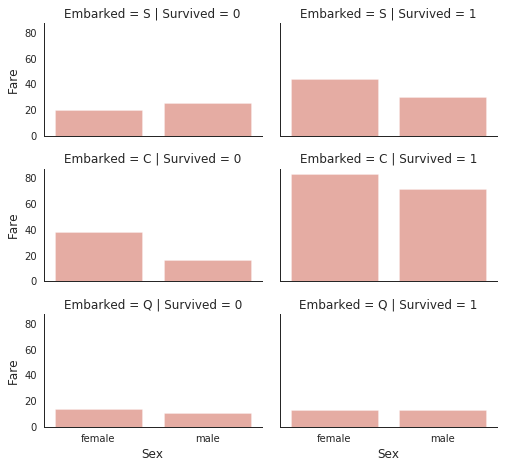

In [31]:
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

In [32]:
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

In [33]:
train_df['Sex'] = train_df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

In [34]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_cat
0,0,3,0,22.0,1,0,7.2500,S,Young
1,1,1,1,38.0,1,0,71.2833,C,Young
2,1,3,1,26.0,0,0,7.9250,S,Young
3,1,1,1,35.0,1,0,53.1000,S,Young
4,0,3,0,35.0,0,0,8.0500,S,Young


In [35]:
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1

In [36]:
X=train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

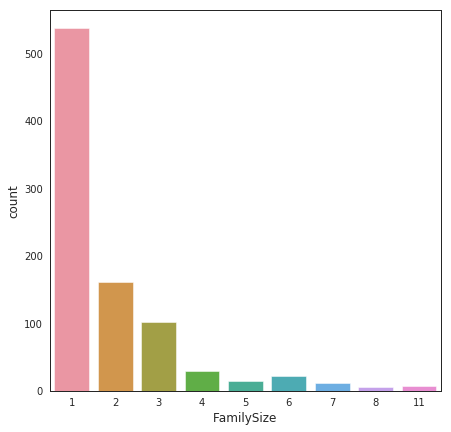

In [37]:
sns.countplot(train_df["FamilySize"])

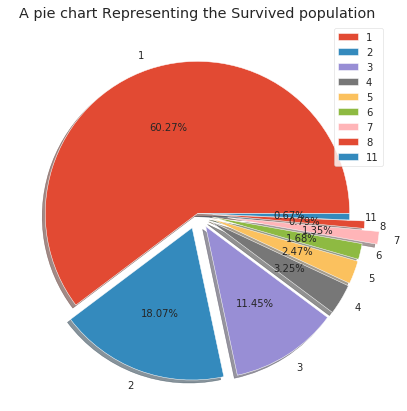

In [38]:
labels = ['1','2','3','4','5','6','7','8','11']
size = train_df['FamilySize'].value_counts()
#colors = ['red', 'green']
explode = [0, 0.1,0.1,0.1,0.1,0.1,0.2,0.1,0]

plt.rcParams['figure.figsize'] = (7, 7)
plt.pie(size, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('A pie chart Representing the Survived population')
plt.axis('off')
plt.legend()
plt.show()

In [39]:
train_df['IsAlone'] = 0
train_df.loc[train_df['FamilySize'] == 1, 'IsAlone'] = 1

In [40]:
train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


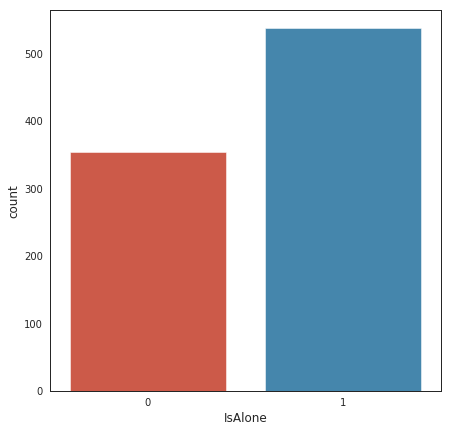

In [41]:
sns.countplot(train_df["IsAlone"])

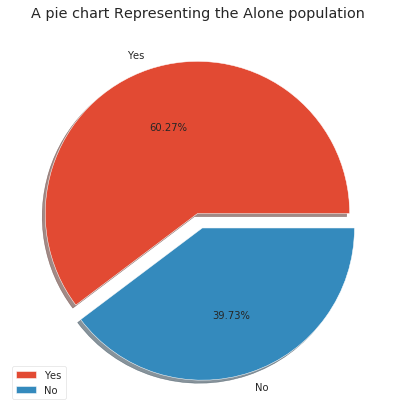

In [42]:
labels = ["Yes","No"]
size = train_df['IsAlone'].value_counts()
#colors = ['red', 'green']
explode = [0, 0.1]

plt.rcParams['figure.figsize'] = (7, 7)
plt.pie(size, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('A pie chart Representing the Alone population')
plt.axis('off')
plt.legend()
plt.show()

In [43]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)

In [44]:
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Age_cat,IsAlone
0,0,3,0,22.0,7.2500,S,Young,0
1,1,1,1,38.0,71.2833,C,Young,0
2,1,3,1,26.0,7.9250,S,Young,1
3,1,1,1,35.0,53.1000,S,Young,0
4,0,3,0,35.0,8.0500,S,Young,1


In [46]:
train_df['Embarked'] = train_df['Embarked'].dropna().map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [47]:
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Age_cat,IsAlone
0,0,3,0,22.0,7.2500,0.0,Young,0
1,1,1,1,38.0,71.2833,1.0,Young,0
2,1,3,1,26.0,7.9250,0.0,Young,1
3,1,1,1,35.0,53.1000,0.0,Young,0
4,0,3,0,35.0,8.0500,0.0,Young,1


In [48]:
train_df=train_df.drop("Age",axis=1)

In [49]:
train_df.head()

,Survived,Pclass,Sex,Fare,Embarked,Age_cat,IsAlone
0,0,3,0,7.2500,0.0,Young,0
1,1,1,1,71.2833,1.0,Young,0
2,1,3,1,7.9250,0.0,Young,1
3,1,1,1,53.1000,0.0,Young,0
4,0,3,0,8.0500,0.0,Young,1


This is our refine dataframe now we can build model with it.